Found 10742 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/train
Found 10742 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/train
Found 1144 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/val
Found 1144 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/val
Found 3749 images in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/test
Found 3749 labels in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/labels/test


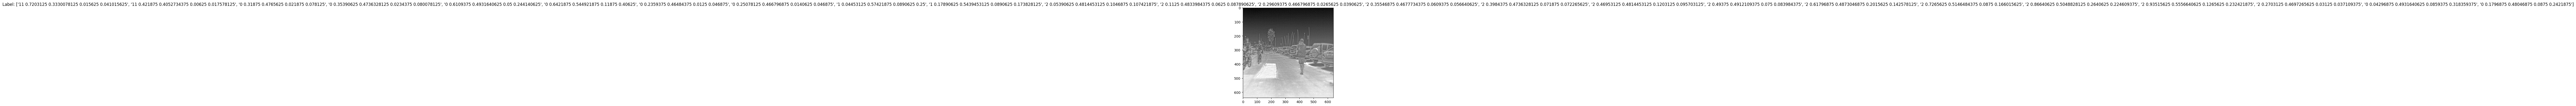

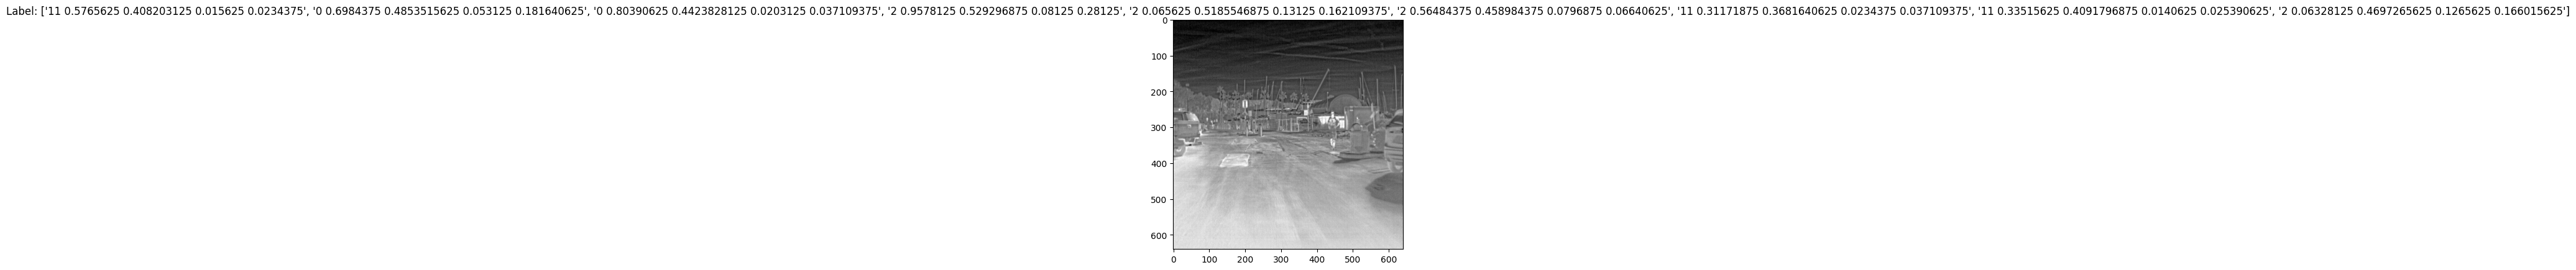

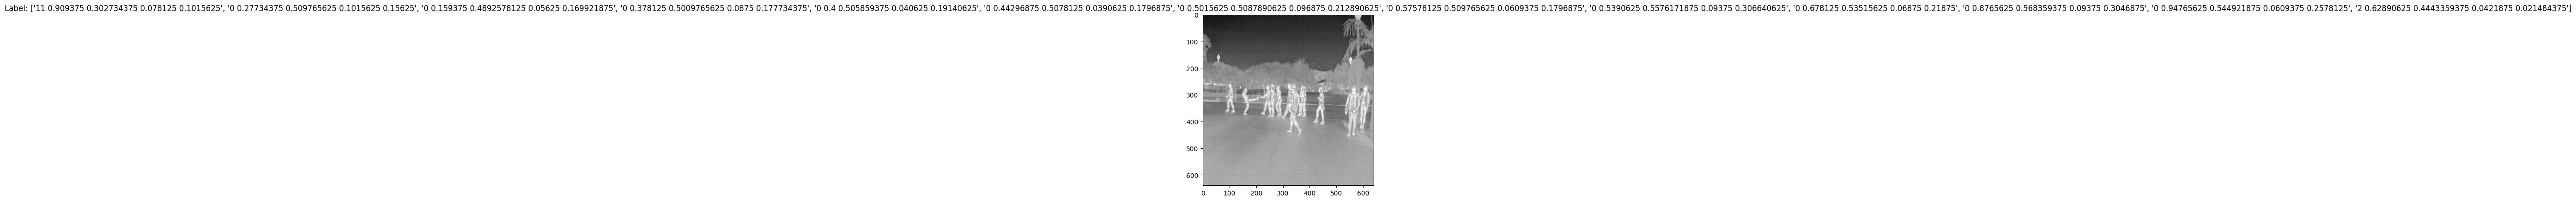

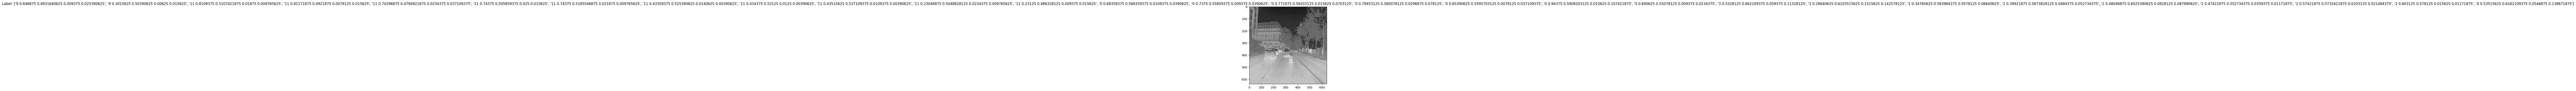

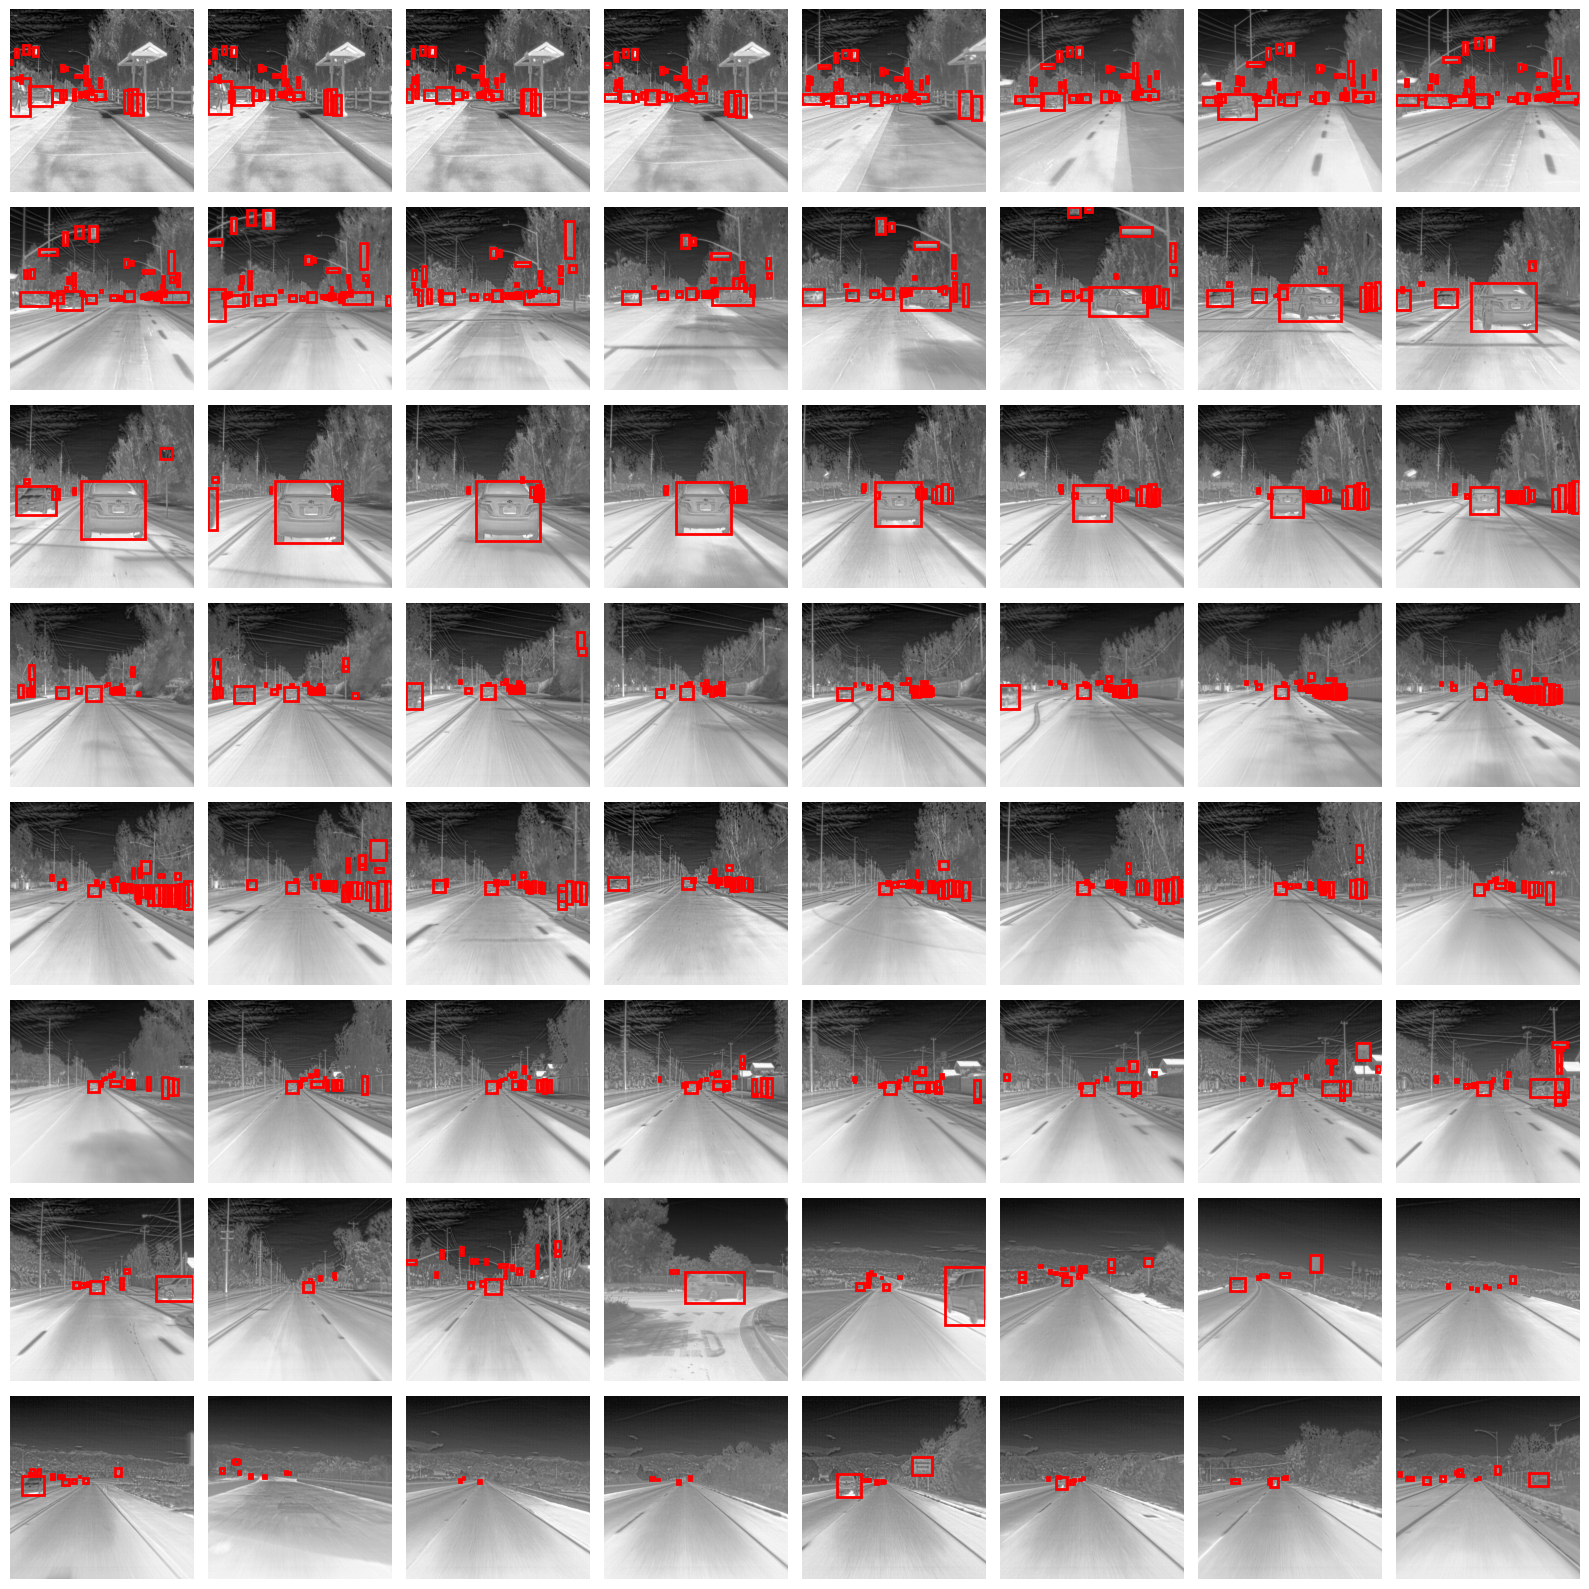

In [30]:
### Cell 1: Import Necessary Libraries
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

### Cell 2: Define Utility Functions

def convert_to_single_channel(img):
    """
    Converts a 3-channel image (RGB/BGR) to a single channel (grayscale).

    Args:
        img (np.ndarray): Input image, shape (H, W, 3).

    Returns:
        np.ndarray: Single-channel image, shape (H, W).
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype(np.float32) / 255.0  # Normalize to range [0, 1]
    return img_gray

### Cell 3: Define YOLO Dataset Class

class YoloThermalDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(640, 640)):
        """
        Initialize the YOLO dataset for thermal images.

        Args:
            image_dir (str): Path to the directory containing images.
            label_dir (str): Path to the directory containing labels.
            transform (callable, optional): Transform to apply to images and labels.
            target_size (tuple): Target size to resize images (height, width).
        """
        self.image_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.label_paths = sorted(Path(label_dir).glob("*.txt"))
        self.transform = transform
        self.target_size = target_size  # Target size for resizing

        # Check for mismatches and missing data
        if not self.image_paths:
            raise FileNotFoundError(f"No images found in {image_dir}")
        if not self.label_paths:
            raise FileNotFoundError(f"No labels found in {label_dir}")
        
        # Filter label paths to match image paths
        self.image_paths, self.label_paths = self._filter_matching_files(self.image_paths, self.label_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        img = cv2.imread(str(img_path))
        img = convert_to_single_channel(img)  # Convert to single-channel

        # Resize the image to the target size
        img = cv2.resize(img, self.target_size)

        # Add a channel dimension to the grayscale image
        img = np.expand_dims(img, axis=0)  # Shape: (1, H, W)

        # Convert image to a torch tensor
        img = torch.tensor(img, dtype=torch.float32)

        # Load label
        with open(label_path, 'r') as f:
            labels = [line.strip() for line in f.readlines()]

        return img, labels

    @staticmethod
    def _filter_matching_files(image_paths, label_paths):
        """
        Ensures each image has a corresponding label file by matching base filenames.

        Args:
            image_paths (list): List of image paths.
            label_paths (list): List of label paths.

        Returns:
            Tuple[list, list]: Filtered image and label paths.
        """
        image_basenames = {p.stem for p in image_paths}
        label_basenames = {p.stem for p in label_paths}
        common_basenames = image_basenames & label_basenames

        filtered_images = [p for p in image_paths if p.stem in common_basenames]
        filtered_labels = [p for p in label_paths if p.stem in common_basenames]

        if len(filtered_images) != len(filtered_labels):
            print(f"Warning: Mismatch after filtering. {len(filtered_images)} images and {len(filtered_labels)} labels.")

        return filtered_images, filtered_labels

### Cell 4: Instantiate Datasets and DataLoaders

# Dataset paths
base_dir = os.path.expanduser("~/projects/YOLO-RGB-T/notebooks/FLIR/T")
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Verify dataset directories and content
def check_dataset_paths(image_dir, label_dir):
    """Utility to check if dataset paths and files are valid."""
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(label_dir):
        raise FileNotFoundError(f"Label directory not found: {label_dir}")
    print(f"Found {len(list(Path(image_dir).glob('*.jpg')))} images in {image_dir}")
    print(f"Found {len(list(Path(label_dir).glob('*.txt')))} labels in {label_dir}")

check_dataset_paths(os.path.join(image_dir, "train"), os.path.join(label_dir, "train"))
check_dataset_paths(os.path.join(image_dir, "val"), os.path.join(label_dir, "val"))
check_dataset_paths(os.path.join(image_dir, "test"), os.path.join(label_dir, "test"))

train_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "train"),
    label_dir=os.path.join(label_dir, "train"),
    target_size=(640, 640)  # Resize all images to 640x640
)

val_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "val"),
    label_dir=os.path.join(label_dir, "val"),
    target_size=(640, 640)
)

test_dataset = YoloThermalDataset(
    image_dir=os.path.join(image_dir, "test"),
    label_dir=os.path.join(label_dir, "test"),
    target_size=(640, 640)
)

# Define a custom collate function
def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-length labels.
    Args:
        batch: A list of (image, label) tuples.
    Returns:
        images: A tensor batch of images.
        labels: A list of labels.
    """
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a tensor
    return images, labels

# DataLoaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

### Cell 5: Test the DataLoader

for imgs, labels in train_loader:
    for img, label in zip(imgs, labels):
        plt.imshow(img[0].numpy(), cmap='gray')  # img[0] removes channel dimension for display
        plt.title(f"Label: {label}")
        plt.show()
    break  # Display one batch

### Cell 6: Plot Bounding Boxes in an 8x8 Matrix

def plot_bboxes(dataset, num_images=64):
    """
    Plot bounding boxes from the dataset in an 8x8 grid.

    Args:
        dataset (Dataset): The dataset to visualize.
        num_images (int): Total number of images to display (default: 64).
    """
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(min(num_images, len(dataset))):
        img, labels = dataset[i]
        img = img.squeeze(0).numpy()  # Remove channel dimension

        # Plot the image
        ax = axes[i]
        ax.imshow(img, cmap='gray')

        # Plot bounding boxes
        for label in labels:
            bbox = list(map(float, label.split()[1:]))  # YOLO format: class x_center y_center width height
            x_center, y_center, width, height = bbox

            # Convert from relative to absolute coordinates
            x_center *= img.shape[1]
            y_center *= img.shape[0]
            width *= img.shape[1]
            height *= img.shape[0]

            # Calculate box corners
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            # Draw the rectangle
            rect = plt.Rectangle((x1, y1), width, height, edgecolor='red', facecolor='none', lw=2)
            ax.add_patch(rect)

        ax.axis('off')

    # Hide remaining axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Test the plot_bboxes function
plot_bboxes(train_dataset)


In [42]:
import os
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics.utils.torch_utils import torch_distributed_zero_first

# Custom dataset and trainer remain as previously defined (YoloThermalDataset and CustomTrainer)

if __name__ == "__main__":
    # Paths
    data_config_path = "/home/dylan/projects/YOLO-RGB-T/data-T.yaml"
    model_config_path = "/home/dylan/projects/YOLO-RGB-T/YOLOv11-T.yaml"

    # Initialize the trainer
    trainer = CustomTrainer(
        overrides={
            "model": model_config_path,  # Model configuration file
            "data": data_config_path,    # Path to the YAML file
            "epochs": 50,                # Number of epochs
            "batch": 16,                 # Batch size
            "imgsz": 640                 # Image size for training and validation
        }
    )

    # Train the model
    trainer.train()

    # Validate the model
    results = trainer.model.val()
    print("Validation Results:", results)


Ultralytics 8.3.33 🚀 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16073MiB)
engine/trainer: task=detect, mode=train, model=/home/dylan/projects/YOLO-RGB-T/YOLOv11-T.yaml, data=/home/dylan/projects/YOLO-RGB-T/data-T.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

FileNotFoundError: No images found in /home/dylan/projects/YOLO-RGB-T/notebooks/FLIR/T/images/train/images/train